# Cortical Magnification

## Introduction

### Dependencies

In [2]:
import os, sys, pimms, pandas, warnings
from pathlib import Path
from functools import reduce, partial

import numpy as np
import scipy as sp
import nibabel as nib
import neuropythy as ny
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyvolume as ipv
import torch

# This library is the companion to the notebook; it can be found in the src/
# directory of the github repository containing this notebook
# (github.com/noahbenson/cortical-magnification).
sys.path.append('../src')
import cmag

/home/lindazelinzhou/.conda/envs/neuro/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Dependency Initialization

In [3]:
# Additional matplotlib preferences:
font_data = {
    'family': 'sans-serif',
    'sans-serif': ['Arial', 'HelveticaNeue', 'Helvetica', 'Arial'],
    'size': 10,
    'weight': 'light'}
mpl.rc('font', **font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 288
mpl.rcParams['savefig.dpi'] = 576
mpl.rcParams['axes.unicode_minus'] = True

## Fitting Functions

#### Filters for use in Fitting

In [4]:
def filt_base(subdat, maxecc=7):
    return (subdat['eccentricity'] < maxecc)
def filt_wedge(subdat, minangle, maxangle):
    ang = subdat['polar_angle']
    return filt_base(subdat) & (ang >= minangle) & (ang <= maxangle)
def filt_ring(subdat, minecc, maxecc):
    ecc = subdat['eccentricity']
    return filt_base(subdat) & (ecc >= minecc) & (ecc <= maxecc)
def filt_sect(subdat, minang, maxang, minecc, maxecc):
    return (
        filt_base(subdat) &
        filt_wedge(subdat, minang, maxang) & 
        filt_ring(subdat, minecc, maxecc))

## Loading Data

In [5]:
# The subject IDs.
sids = cmag.hcp.sids

# The data for each subject.
data = {
    sid: (
        cmag.hcp.data.load(sid, 'lh'),
        cmag.hcp.data.load(sid, 'rh'))
    for sid in sids}

In [6]:
np.unique(data[111312][1]['label'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

## Fitting

In [8]:
# We'll use this subject as an example:
(lhdata, rhdata) = data[111312]

In [9]:
# First, fit the Horton & Hoyt (1991) model:

fit_lh = cmag.hcp.fit_cmag_data(
    lhdata,
    cmag.models.hh91, [1],
    hemifields=1,
    labels=1)
fit_rh = cmag.hcp.fit_cmag_data(
    rhdata,
    cmag.models.hh91, [1],
    hemifields=1,
    labels=1)
fit_lr = cmag.hcp.fit_cmag_data(
    (lhdata, rhdata),
    cmag.models.hh91, [1],
    hemifields=2,
    labels=1)

print('HH91 Model:')
for (k,f) in zip(['lh', 'rh', 'lr'], [fit_lh, fit_rh, fit_lr]):
    print(f' - {k}: total_area={float(f["total_area"]):7.2f}, b={float(f["x"][0]):5.3f}')

HH91 Model:
 - lh: total_area=5489.41, b=0.445
 - rh: total_area=6919.87, b=0.752
 - lr: total_area=6120.73, b=0.577


In [11]:
df = dict(sid=[], h=[], label=[], total_area=[], b=[], loss=[])

import warnings
warnings.filterwarnings("default")
for i in sids:
    (lhdata, rhdata) = data[i]
    for lbl in [1,2,3,4]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)  # Ignore RuntimeWarnings
                fit = cmag.hcp.fit_cmag_data(
                (lhdata, rhdata),
                cmag.models.hh91, [1],
                hemifields=2,
                labels=lbl)
        except Exception as e:
            print(f"  - Skipping: {type(e)}", i, lbl)
            continue
        df['sid'].append(i)
        df['h'].append('lr')
        df['label'].append(lbl)
        df['total_area'].append(fit["total_area"])
        df['b'].append(fit.x[0])
        df['loss'].append(fit.fun)
        
HH91_params = pd.DataFrame(df)


In [12]:
HH91_params  # total area lh+rh for each visual area

,sid,h,label,total_area,b,loss
0,100610,lr,1,11301.624595,0.692820,4041.027053
1,100610,lr,2,7034.892932,0.261806,11238.652143
2,100610,lr,3,4504.585463,0.167536,3250.105332
3,100610,lr,4,3018.756528,0.163715,3907.259116
4,118225,lr,1,11089.432231,0.674607,5136.165569
...,...,...,...,...,...,...
719,818859,lr,4,2421.135232,0.196341,1797.291231
720,901442,lr,1,6100.389887,0.825829,1162.682685
721,901442,lr,2,4635.913403,0.455664,3004.777464
722,901442,lr,3,3870.102561,0.309039,2490.238409


In [ ]:
# Then fit the Beta distribution model:

fit_lh = cmag.hcp.fit_cmag_data(
    lhdata,
    cmag.models.beta, [0.8, 2.5],
    hemifields=1,
    labels=1)
fit_rh = cmag.hcp.fit_cmag_data(
    rhdata,
    cmag.models.beta, [0.8, 2.5],
    hemifields=1,
    labels=1)
fit_lr = cmag.hcp.fit_cmag_data(
    (lhdata, rhdata),
    cmag.models.beta, [0.8, 2.5],
    hemifields=2,
    labels=1)

print('Beta Model:')
for (k,f) in zip(['lh', 'rh', 'lr'], [fit_lh, fit_rh, fit_lr]):
    print(
        f' - {k}: total_area={float(f["total_area"]):7.2f},'
        f' a={float(f["x"][0]):5.3f},'
        f' b={float(f["x"][1]):5.3f}')

# HH91_params for 4 wedges, each is 90 degree

In [13]:
df = dict(sid=[], h=[], label=[], total_area=[], b=[], loss=[])

for i in sids:
    (lhdata,rhdata) = data[i]
    for lbl in [1,2,3,4]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)  # Ignore RuntimeWarnings
                lhmfit = cmag.hcp.fit_cmag_data(
                    (lhdata,rhdata),
                    cmag.models.hh91, [1],
                    hemifields=2*(90/360),
                    filter=lambda data: filt_wedge(data, -135, -45),
                    labels=lbl)
        except Exception as e:
            print(f"  - Skipping: {type(e)}")
            continue
        df['sid'].append(i)
        df['h'].append('lr')
        df['label'].append(lbl)
        df['total_area'].append(lhmfit["total_area"])
        df['b'].append(lhmfit.x[0])
        df['loss'].append(lhmfit.fun)
        
HH91_params_lhm = pd.DataFrame(df)


In [14]:
df = dict(sid=[], h=[], label=[], total_area=[], b=[], loss=[])

for i in sids:
    (lhdata,rhdata) = data[i]
    for lbl in [1,2,3,4]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)  # Ignore RuntimeWarnings
                rhmfit = cmag.hcp.fit_cmag_data(
                (lhdata,rhdata),
                cmag.models.hh91, [1],
                hemifields=2*(90/360),
                filter=lambda lhdata: filt_wedge(lhdata, 45, 135),
                labels=lbl)
        except Exception as e:
            print(f"  - Skipping: {type(e)}")
            continue
        df['sid'].append(i)
        df['h'].append('lr')
        df['label'].append(lbl)
        df['total_area'].append(rhmfit["total_area"])
        df['b'].append(rhmfit.x[0])
        df['loss'].append(rhmfit.fun)
        
HH91_params_rhm = pd.DataFrame(df)

In [15]:
df = dict(sid=[], h=[], label=[], total_area=[], b=[], loss=[])

for i in sids:
    subdata = data[i]
    (lhdata, rhdata) = data[i]
    for lbl in [1,2,3,4]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)  # Ignore RuntimeWarnings
                uvmfit = cmag.hcp.fit_cmag_data(
                (lhdata, rhdata),
                cmag.models.hh91, [1],
                hemifields=2*(90/360),
                filter=lambda subdata: filt_wedge(subdata, -45, 45),
                labels=lbl)
        except Exception as e:
            print(f"  - Skipping: {type(e)}")
            continue
        df['sid'].append(i)
        df['h'].append('lr')
        df['label'].append(lbl)
        df['total_area'].append(uvmfit["total_area"])
        df['b'].append(uvmfit.x[0])
        df['loss'].append(uvmfit.fun)
        
HH91_params_uvm = pd.DataFrame(df)

In [16]:
df = dict(sid=[], h=[], label=[], total_area=[], b=[], loss=[])

for i in sids:
    subdata = data[i]
    (lhdata, rhdata) = data[i]
    for lbl in [1,2,3,4]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)  # Ignore RuntimeWarnings
                lvmfit = cmag.hcp.fit_cmag_data(
                (lhdata, rhdata),
                cmag.models.hh91, [1],
                hemifields=2*(90/360),
                filter=lambda subdata: filt_wedge(subdata, 135, 180) | filt_wedge(subdata, -180, -135),
                labels=lbl)
        except Exception as e:
            print(f"  - Skipping: {type(e)}")
            continue
        df['sid'].append(i)
        df['h'].append('lr')
        df['label'].append(lbl)
        df['total_area'].append(lvmfit["total_area"])
        df['b'].append(lvmfit.x[0])
        df['loss'].append(lvmfit.fun)
        
HH91_params_lvm = pd.DataFrame(df)

In [ ]:
label = 1
max = 25000
dset = 'Beta'

fig, ax = plt.subplots(figsize=(4,3),dpi=144)
if dset=='HH91':
    df_lvm = HH91_params_lvm[HH91_params_lvm['label']==label]
    df_uvm = HH91_params_uvm[HH91_params_uvm['label']==label]
    df_lhm = HH91_params_lhm[HH91_params_lhm['label']==label]
    df_rhm = HH91_params_rhm[HH91_params_rhm['label']==label]
else:
    df_lvm = Beta_params_lvm[Beta_params_lvm['label']==label]
    df_uvm = Beta_params_uvm[Beta_params_uvm['label']==label]
    df_lhm = Beta_params_lhm[Beta_params_lhm['label']==label]
    df_rhm = Beta_params_rhm[Beta_params_rhm['label']==label]

df_lvm = df_lvm[df_lvm['total_area']<max]
df_uvm = df_uvm[df_uvm['total_area']<max]
df_lhm = df_lhm[df_lhm['total_area']<max]
df_rhm = df_rhm[df_rhm['total_area']<max]

ax.hist([df_lvm['total_area'],df_uvm['total_area'],df_lhm['total_area'],df_rhm['total_area']],
        color = ['r','c','m','g'])
plt.show()

# HH91_params for 12 wedges, each is 30 degree

In [17]:
df = dict(sid=[], h=[], label=[], total_area=[], b=[], loss=[], wedge_center=[])

wedge_bounds = [
    (-15, 15),   # center 0
    (15, 45),    # center 30
    (45, 75),    # center 60
    (75, 105),   # center 90
    (105, 135),  # center 120
    (135, 165),  # center 150
    (165, -165), # center 180 
    (-165, -135),# center -150
    (-135, -105),# center -120
    (-105, -75), # center -90
    (-75, -45),  # center -60
    (-45, -15)   # center -30
]

for i in sids:
    (lhdata, rhdata) = data[i]
    for (wedge_start, wedge_end) in wedge_bounds:
        if wedge_start == 165 and wedge_end == -165:
            wedge_center = 180
            filt_func = lambda data: filt_wedge(data, 165, 180) | filt_wedge(data, -180, -165)
        else:
            wedge_center = (wedge_start + wedge_end) / 2
            filt_func = lambda data: filt_wedge(data, wedge_start, wedge_end)

        for lbl in [1, 2, 3, 4]:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", RuntimeWarning)
                    fit = cmag.hcp.fit_cmag_data(
                        (lhdata, rhdata),
                        cmag.models.hh91, [1],
                        hemifields=2 * (30 / 360),
                        filter=filt_func,
                        labels=lbl
                    )
            except Exception as e:
                print(f"  - Skipping: {type(e)}")
                continue

            if fit is not None:
                df['sid'].append(i)
                df['h'].append('lr')
                df['label'].append(lbl)
                df['total_area'].append(fit["total_area"])
                df['b'].append(fit.x[0])
                df['loss'].append(fit.fun)
                df['wedge_center'].append(wedge_center)
            else:
                #print(f"  - Skipping fit for subject {i}, label {lbl}, wedge {wedge_center}: fit returned None")
                df['sid'].append(i)
                df['h'].append('lr')
                df['label'].append(lbl)
                df['total_area'].append(np.nan)
                df['b'].append(np.nan)
                df['loss'].append(np.nan)
                df['wedge_center'].append(wedge_center)
                
HH91_params_12wedge = pd.DataFrame(df)


### plot cmag vs eccentricity for different wedges

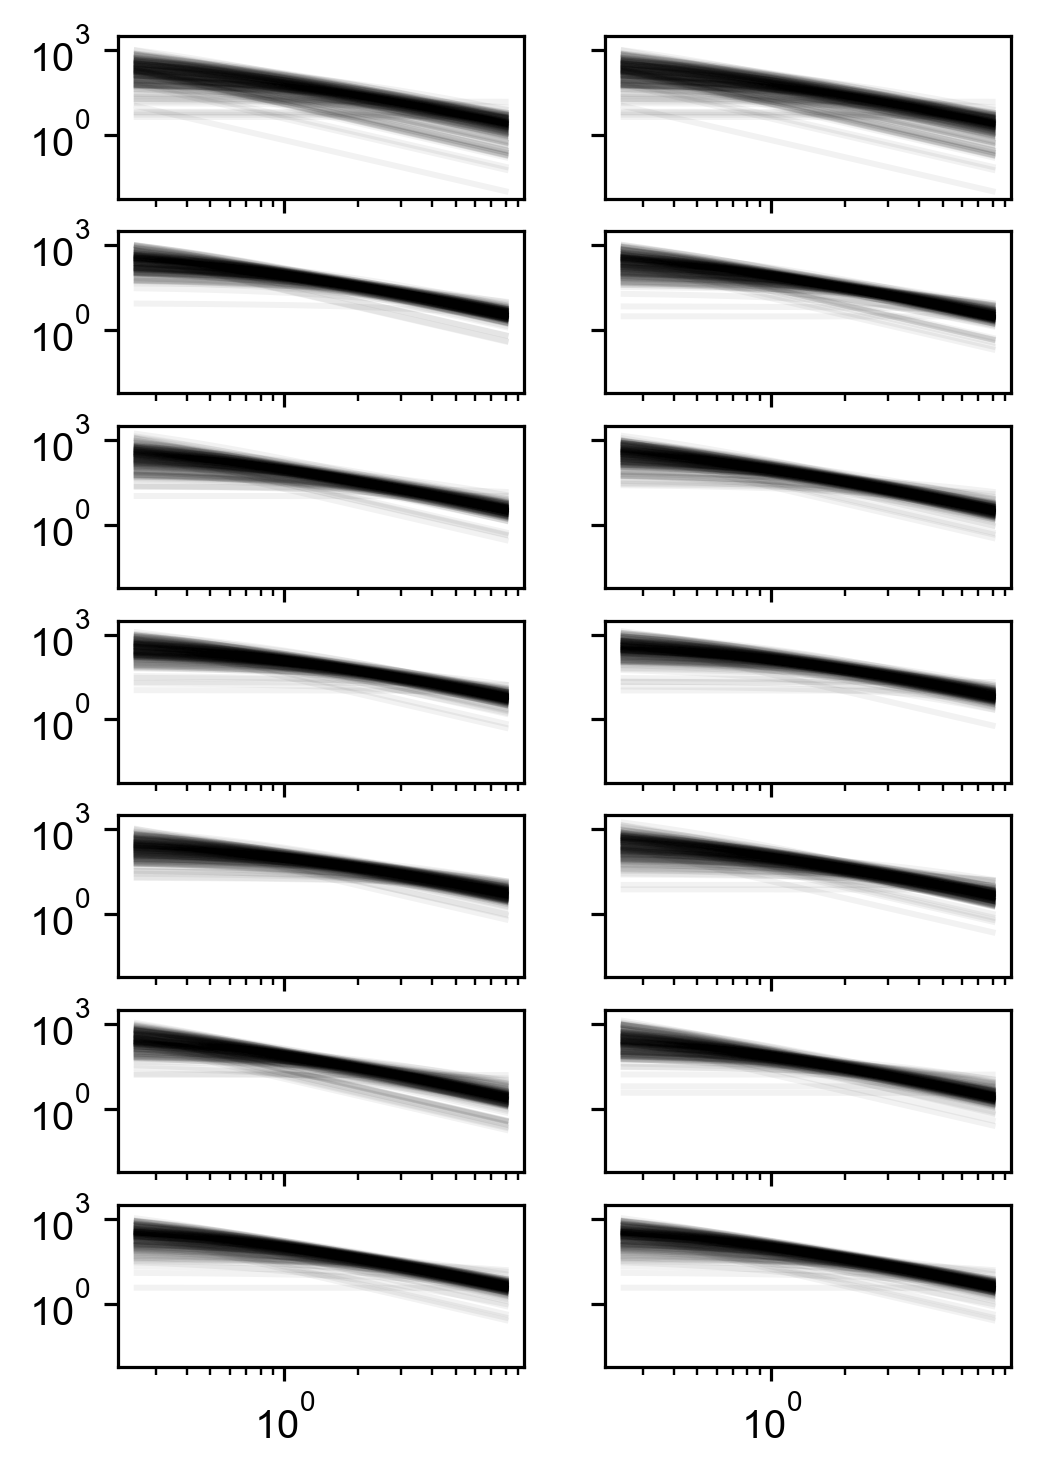

In [21]:
import cmag
df = HH91_params_12wedge

def plot_wedge_cmag_panel(df, label, wedge_center, ax=None, xlim=[0.25, 8], ylim=[0.5, 512]):
    df = df[df['label']==label]
    df = df[df['wedge_center']==wedge_center]
    x = np.logspace(-2, 3, 200, base=2)
    if ax is None:
        ax = plt.gca()
    for _, row in df.iterrows():
        total_area = row['total_area']
        b = row['b']
        if np.isnan(total_area) or np.isnan(b):
            continue
        ax.loglog(x, cmag.models.hh91.radial_cmag(x,total_area,200,b),'k-', alpha=0.05)

fig, axs = plt.subplots(7,2,figsize=(4,6),dpi=288, sharex=True, sharey=True)
l_axs = axs[:,0]
r_axs = axs[:,1]

for (ii, abs_center) in enumerate([0,30,60,90,120,150,180]):
    plot_wedge_cmag_panel(df,1,abs_center,r_axs[ii])
    if abs_center==180 or abs_center==-180:
        abs_center = -180
    plot_wedge_cmag_panel(df,1,-abs_center,l_axs[ii])
   

sid                        200210
h                              lr
label                           4
total_area      19165606622.30481
b                             0.0
loss                          NaN
wedge_center                150.0
Name: 2327, dtype: object
sid                         751550
h                               lr
label                            4
total_area      17864125750.314529
b                              0.0
loss                           NaN
wedge_center                -150.0
Name: 2575, dtype: object


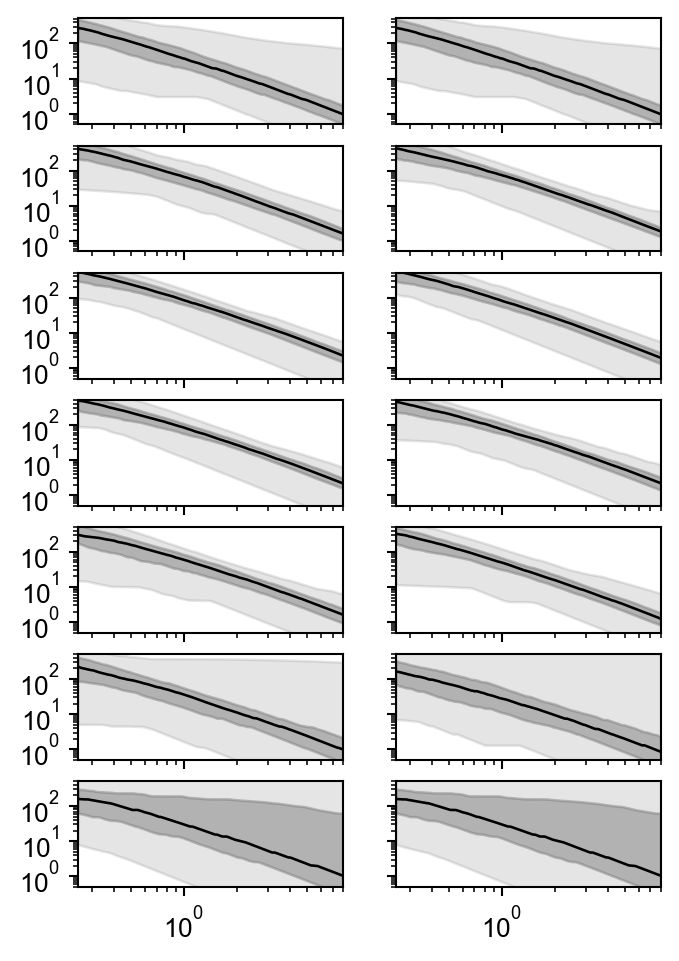

In [38]:
def plot_wedge_cmag_avg(df, label, wedge_center, ax=None, xlim=[0.25, 8], ylim=[0.5, 512]):

    df = df[(df['label'] == label) & (df['wedge_center'] == wedge_center)]
    x = np.logspace(-2, 3, 200, base=2)

    if ax is None:
        ax = plt.gca()

    all_cmag = []

    for _, row in df.iterrows():
        total_area = row['total_area']
        b = row['b']
        if np.isnan(total_area) or np.isnan(b):
            continue
        if total_area == 0:
            continue
        if b==0:
            print(row)
            continue
        cmag_vals = cmag.models.hh91.radial_cmag(x, total_area, 200, b)
        all_cmag.append(cmag_vals)

    all_cmag = np.array(all_cmag)
    
    cmag_2_5, cmag_25, cmag_50, cmag_75, cmag_97_5 = np.percentile(all_cmag, [2.5, 25, 50, 75, 97.5], axis=0)

    # Plot 95% data (light gray)
    ax.fill_between(x, cmag_2_5, cmag_97_5, color='gray', alpha=0.2, label='95% CI')

    # Plot IQR (darker gray)
    ax.fill_between(x, cmag_25, cmag_75, color='gray', alpha=0.5, label='IQR')

    # Plot median
    ax.loglog(x, cmag_50, 'k-', lw=1, label='Median')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig, axs = plt.subplots(7, 2, figsize=(4, 6), dpi=188, sharex=True, sharey=True)
l_axs = axs[:, 0]
r_axs = axs[:, 1]

for (ii, abs_center) in enumerate([0, 30, 60, 90, 120, 150, 180]):
    plot_wedge_cmag_avg(df, 4, abs_center, r_axs[ii])
    if abs_center==180 or abs_center==-180:
        abs_center = -180
    plot_wedge_cmag_avg(df, 4, -abs_center,l_axs[ii])

for ax in axs.flatten():
    ax.label_outer()

### scatterplot of "b" vs "total area" parameters

In [23]:
def plot_wedge_cmag_params(df, label, wedge_center, ax=None):

    df = df[(df['label'] == label) & (df['wedge_center'] == wedge_center)]

    if ax is None:
        ax = plt.gca()
    b = df['b']
    a = df['total_area']
    ok = (b>0) & (b<10)
    b = b[ok]
    a = a[ok]
    ax.scatter(b,a,s=1,c='k',alpha=0.5)
    

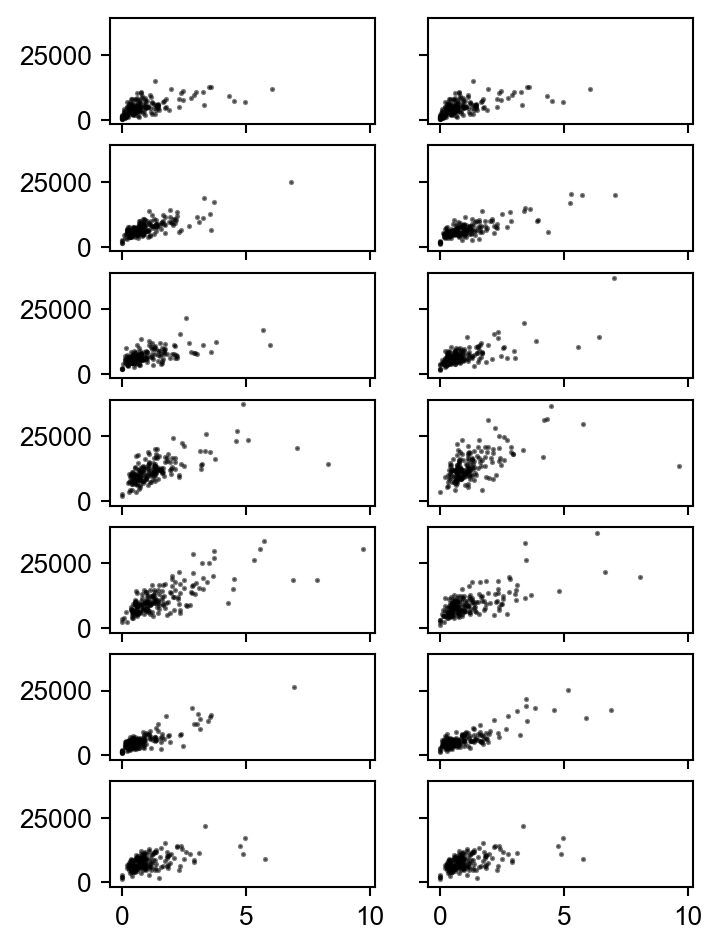

In [24]:
fig, axs = plt.subplots(7, 2, figsize=(4, 6), dpi=188, sharex=True, sharey=True)
l_axs = axs[:, 0]
r_axs = axs[:, 1]

for (ii, abs_center) in enumerate([0, 30, 60, 90, 120, 150, 180]):
    plot_wedge_cmag_params(df, 1, abs_center, r_axs[ii])
    if abs_center==180 or abs_center==-180:
        abs_center = -180
    plot_wedge_cmag_params(df, 1, -abs_center,l_axs[ii])

for ax in axs.flatten():
    ax.label_outer()

### plot "b" (or "total_area") as a function of polar angle

In [25]:
def plot_polar_angle_params(df, label, wedge_center, name='b', ax=None):

    df = df[(df['label'] == label) & (df['wedge_center'] == wedge_center)]

    if ax is None:
        ax = plt.gca()
    b = df['b']
    a = df['total_area']
    ok = (b>0) & (b<10)
    b = b[ok]
    a = a[ok]
    if name=='b':
        x=b
    else:
        x=a
    low, mid, high = np.percentile(x,[25,50,75])
    ax.plot([wedge_center, wedge_center], [low, high], 'k-', lw=0.5)
    ax.plot([wedge_center], [mid], 'ko')

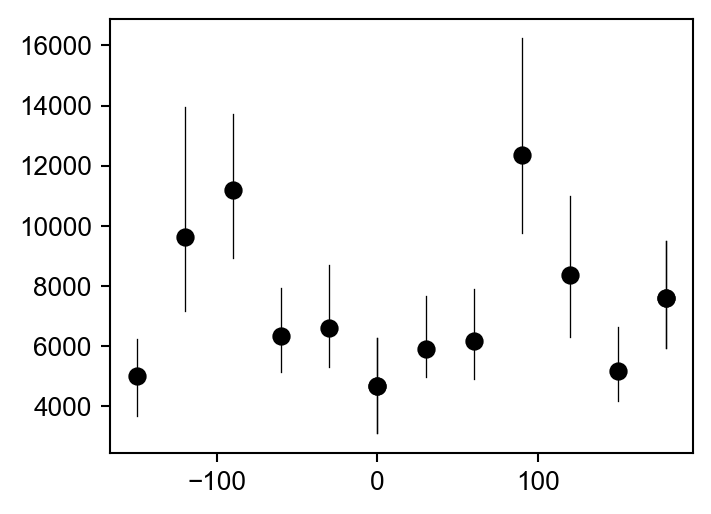

In [26]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=188, sharex=True, sharey=True)

for (ii, abs_center) in enumerate([0, 30, 60, 90, 120, 150, 180]):
    plot_polar_angle_params(df, 1, abs_center, '', ax)
    if abs_center==180 or abs_center==-180:
        abs_center = -180
    plot_polar_angle_params(df, 1, -abs_center,'', ax)


In [27]:
def get_polar_angle_medians(df, label, name='b'):
    """
    Returns a list of (polar_angle, median_value) for the given param ('b' or 'total_area')
    """
    results = []

    for abs_center in [0, 30, 60, 90, 120, 150, 180]:
        for center in [abs_center, -abs_center] if abs_center != 0 else [0]:
            subset = df[(df['label'] == label) & (df['wedge_center'] == center)]
            b = subset['b']
            a = subset['total_area']
            ok = (b > 0) & (b < 10)
            b = b[ok]
            a = a[ok]

            if name == 'b':
                x = b
            else:
                x = a

            if len(x) > 0:
                mid = np.percentile(x, 50)
                results.append((center, mid))

    # sort by polar angle
    results = sorted(results, key=lambda x: x[0])
    return results


In [28]:
# a = get_polar_angle_medians(df, 1, name='total_area')

# using fourier model to fit "total_area" as a function of polar angle

In [ ]:
from scipy.optimize import minimize

Label 1:
f(θ) = -606.561·cos(θ) + -50.008·sin(θ) + -2525.269·cos(2θ) + 29.210·sin(2θ) + 432.518·cos(3θ) + 7417.956
Label 2:
f(θ) = -400.568·cos(θ) + -243.630·sin(θ) + 40.505·cos(2θ) + -26.537·sin(2θ) + -803.117·cos(3θ) + 6144.898
Label 3:
f(θ) = -814.593·cos(θ) + 3.376·sin(θ) + -1930.150·cos(2θ) + 162.442·sin(2θ) + 118.324·cos(3θ) + 4977.428
Label 4:
f(θ) = 993.558·cos(θ) + -182.294·sin(θ) + -1369.578·cos(2θ) + 192.319·sin(2θ) + -297.059·cos(3θ) + 3234.833


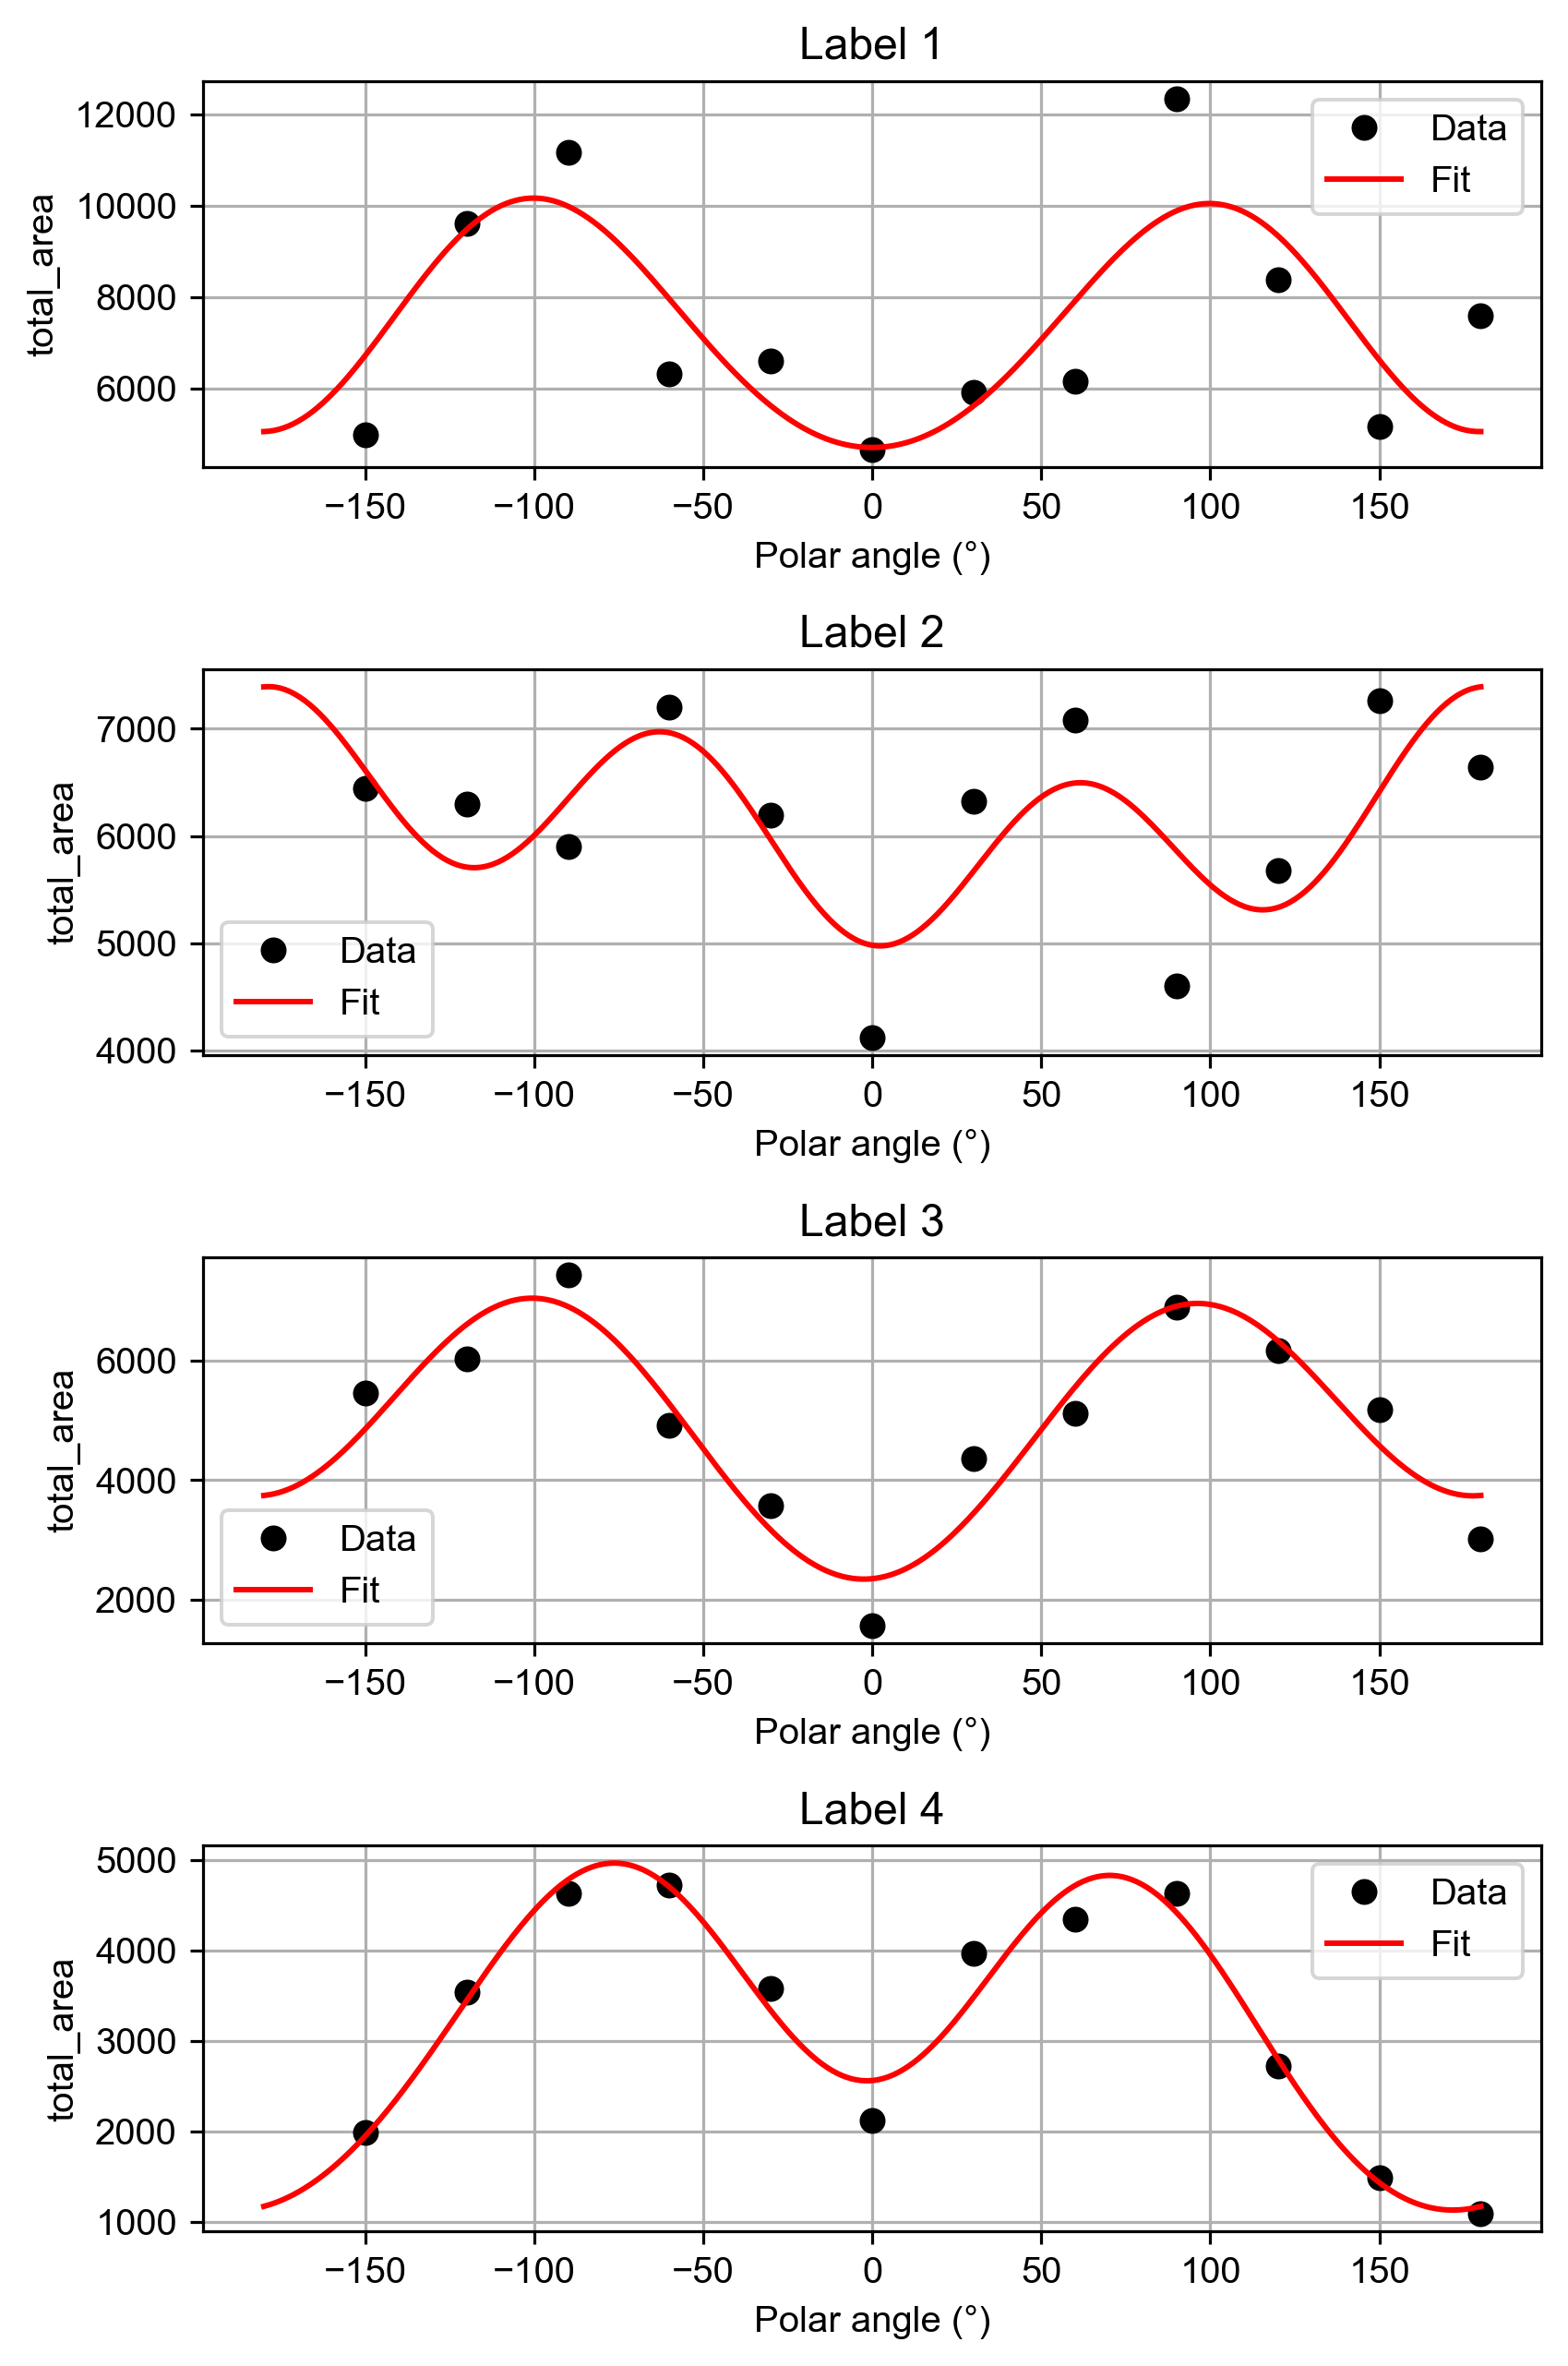

In [293]:
# version 1: initial try
def fourier_model(theta_deg, a0, b1, a1, b2, a2, offset):
    theta_rad = np.radians(theta_deg)
    return (a0 * np.cos(theta_rad) +
            b1 * np.sin(theta_rad) +
            a1 * np.cos(2 * theta_rad) +
            b2 * np.sin(2 * theta_rad) +
            a2 * np.cos(3 * theta_rad) +
            offset)

def loss_fourier(params, theta, y):
    return np.mean((fourier_model(theta, *params) - y) ** 2)

def fit_fourier_model(theta, y):
    params0 = [0, 0, 0, 0, 0, np.mean(y)]
    result = minimize(loss_fourier, x0=params0, args=(theta, y))
    return result

def print_equation(label, params):
    a0, b1, a1, b2, a2, offset = params
    equation = (f"Label {label}:\n"
                f"f(θ) = {a0:.3f}·cos(θ) + {b1:.3f}·sin(θ) + "
                f"{a1:.3f}·cos(2θ) + {b2:.3f}·sin(2θ) + "
                f"{a2:.3f}·cos(3θ) + {offset:.3f}")
    print(equation)

# Plot fits for each label
labels_to_fit = [1, 2, 3, 4]
fig, axs = plt.subplots(len(labels_to_fit), 1, figsize=(6, 9))

for idx, label in enumerate(labels_to_fit):
    data = get_polar_angle_medians(df, label=label, name='')
    if not data:
        continue
    theta_vals, y_vals = zip(*data)
    fit_result = fit_fourier_model(theta_vals, y_vals)
    fit_params = fit_result.x
    y_pred = fourier_model(np.linspace(-180, 180, 500), *fit_params)

    # Print equation
    print_equation(label, fit_params)

    # Plot
    ax = axs[idx]
    ax.plot(theta_vals, y_vals, 'ko', label='Data')
    ax.plot(np.linspace(-180, 180, 500), y_pred, 'r-', label='Fit')
    ax.set_title(f'Label {label}')
    ax.set_ylabel('total_area')
    ax.set_xlabel('Polar angle (°)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

Label 1:
f(θ) = -606.568·cos(θ) + -50.019·sin(θ) + -2525.275·cos(2θ) + 29.186·sin(2θ) + 432.511·cos(3θ) + -281.207·sin(3θ) + 1533.078·cos(4θ) + 7417.954
Label 2:
f(θ) = -400.566·cos(θ) + -243.629·sin(θ) + 40.509·cos(2θ) + -26.537·sin(2θ) + -803.115·cos(3θ) + 373.543·sin(3θ) + -827.666·cos(4θ) + 6144.897
Label 3:
f(θ) = -814.590·cos(θ) + 3.381·sin(θ) + -1930.154·cos(2θ) + 162.449·sin(2θ) + 118.323·cos(3θ) + 173.417·sin(3θ) + -248.226·cos(4θ) + 4977.429
Label 4:
f(θ) = 993.556·cos(θ) + -182.294·sin(θ) + -1369.579·cos(2θ) + 192.319·sin(2θ) + -297.060·cos(3θ) + -20.098·sin(3θ) + -117.400·cos(4θ) + 3234.833


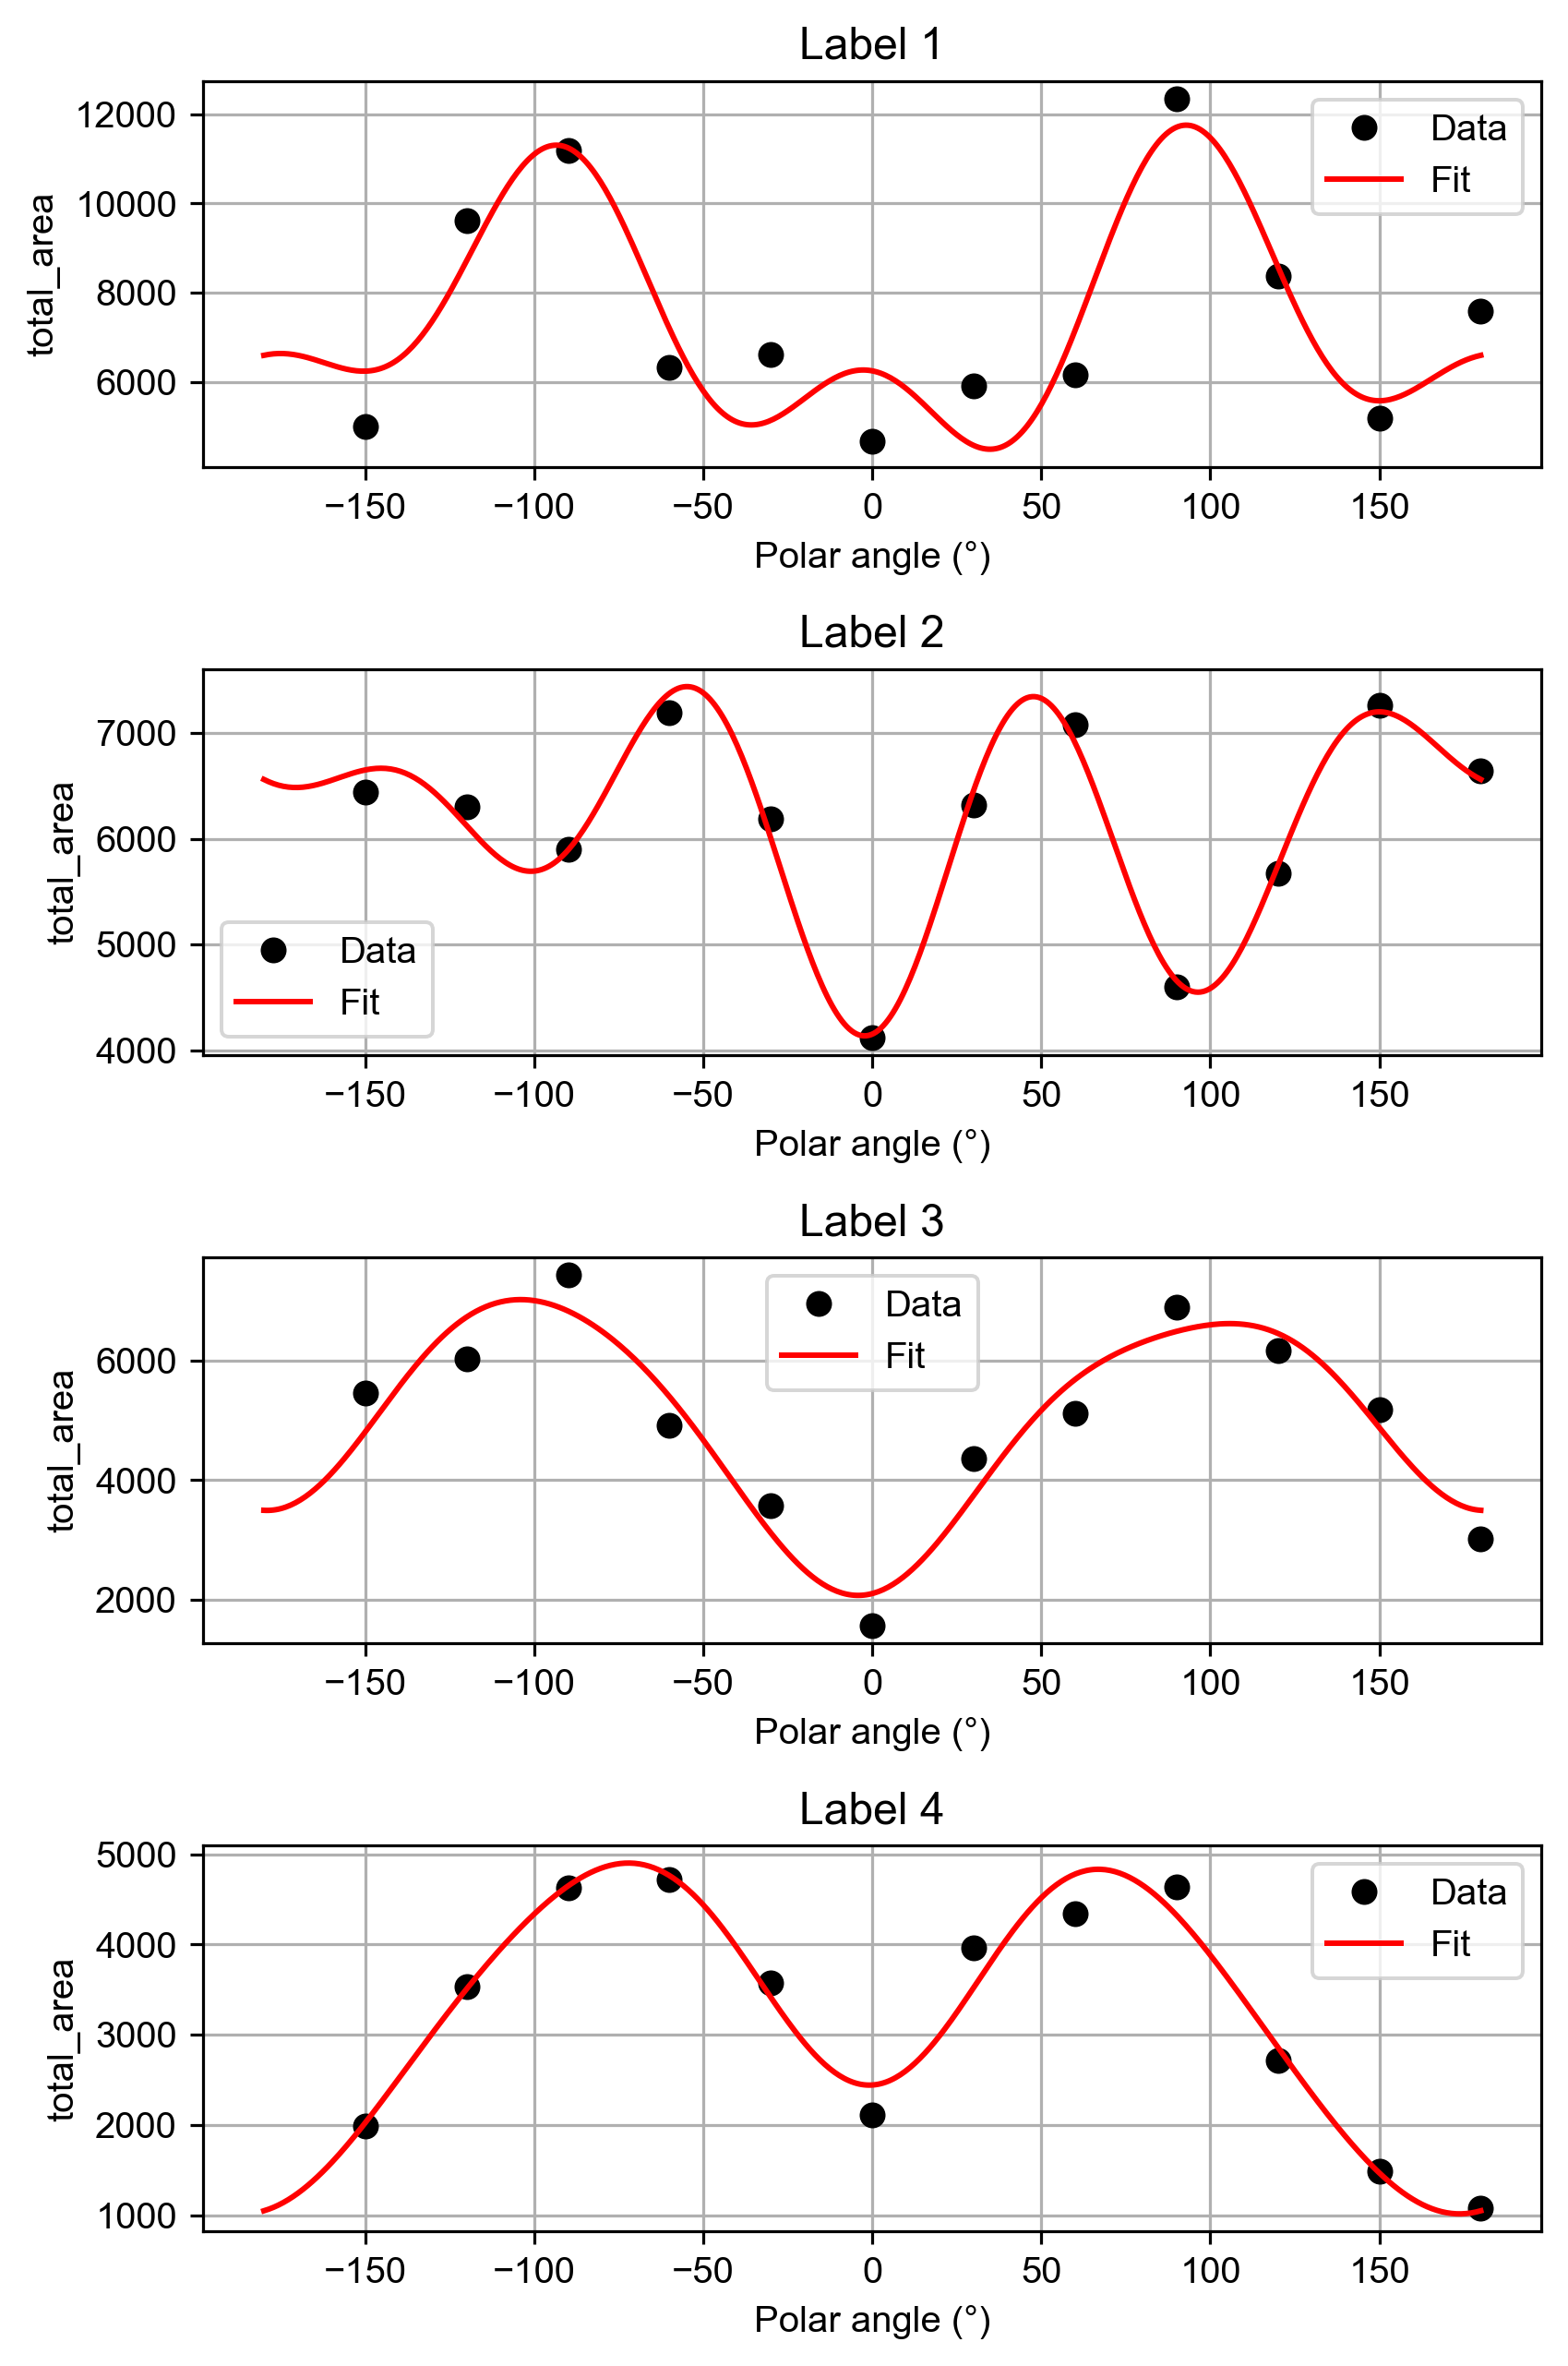

In [43]:
# version 2: with more params, adding cos(4 theta), try to capture the pattern variation every 90°
def fourier_model(theta_deg, a0, b1, a1, b2, a2, b3, a3, offset):
    theta_rad = np.radians(theta_deg)
    return (a0 * np.cos(theta_rad) +
            b1 * np.sin(theta_rad) +
            a1 * np.cos(2 * theta_rad) +
            b2 * np.sin(2 * theta_rad) +
            a2 * np.cos(3 * theta_rad) +
            b3 * np.sin(3 * theta_rad) +
            a3 * np.cos(4 * theta_rad) +
            offset)

def loss_fourier(params, theta, y):
    return np.mean((fourier_model(theta, *params) - y) ** 2)

def fit_fourier_model(theta, y):
    params0 = [0] * 7 + [np.mean(y)]
    result = minimize(loss_fourier, x0=params0, args=(theta, y))
    return result

def print_equation(label, params):
    a0, b1, a1, b2, a2, b3, a3, offset = params
    equation = (f"Label {label}:\n"
                f"f(θ) = {a0:.3f}·cos(θ) + {b1:.3f}·sin(θ) + "
                f"{a1:.3f}·cos(2θ) + {b2:.3f}·sin(2θ) + "
                f"{a2:.3f}·cos(3θ) + {b3:.3f}·sin(3θ) + "
                f"{a3:.3f}·cos(4θ) + {offset:.3f}")
    print(equation)

labels_to_fit = [1, 2, 3, 4]
fig, axs = plt.subplots(len(labels_to_fit), 1, figsize=(6, 9))

for idx, label in enumerate(labels_to_fit):
    data = get_polar_angle_medians(df, label=label, name='')
    if not data:
        continue
    theta_vals, y_vals = zip(*data)
    fit_result = fit_fourier_model(theta_vals, y_vals)
    fit_params = fit_result.x
    theta_pred = np.linspace(-180, 180, 500)
    y_pred = fourier_model(theta_pred, *fit_params)

    print_equation(label, fit_params)

    ax = axs[idx]
    ax.plot(theta_vals, y_vals, 'ko', label='Data')
    ax.plot(theta_pred, y_pred, 'r-', label='Fit')
    ax.set_title(f'Label {label}')
    ax.set_ylabel('total_area')
    ax.set_xlabel('Polar angle (°)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Label 1:
f(θ) = -606.560·cos(θ) + -50.021·sin(θ) + -2525.270·cos(2θ) + 29.204·sin(2θ) + 432.513·cos(3θ) + -281.210·sin(3θ) + 1533.075·cos(4θ) + -280.607·sin(4θ) + -1281.427·cos(5θ) + 7417.954
Label 2:
f(θ) = -400.567·cos(θ) + -243.628·sin(θ) + 40.509·cos(2θ) + -26.537·sin(2θ) + -803.115·cos(3θ) + 373.543·sin(3θ) + -827.666·cos(4θ) + -173.222·sin(4θ) + -56.161·cos(5θ) + 6144.897
Label 3:
f(θ) = -814.590·cos(θ) + 3.378·sin(θ) + -1930.151·cos(2θ) + 162.449·sin(2θ) + 118.324·cos(3θ) + 173.420·sin(3θ) + -248.228·cos(4θ) + 141.635·sin(4θ) + -29.827·cos(5θ) + 4977.428
Label 4:
f(θ) = 993.557·cos(θ) + -182.294·sin(θ) + -1369.578·cos(2θ) + 192.319·sin(2θ) + -297.060·cos(3θ) + -20.098·sin(3θ) + -117.399·cos(4θ) + 65.462·sin(4θ) + -180.334·cos(5θ) + 3234.833


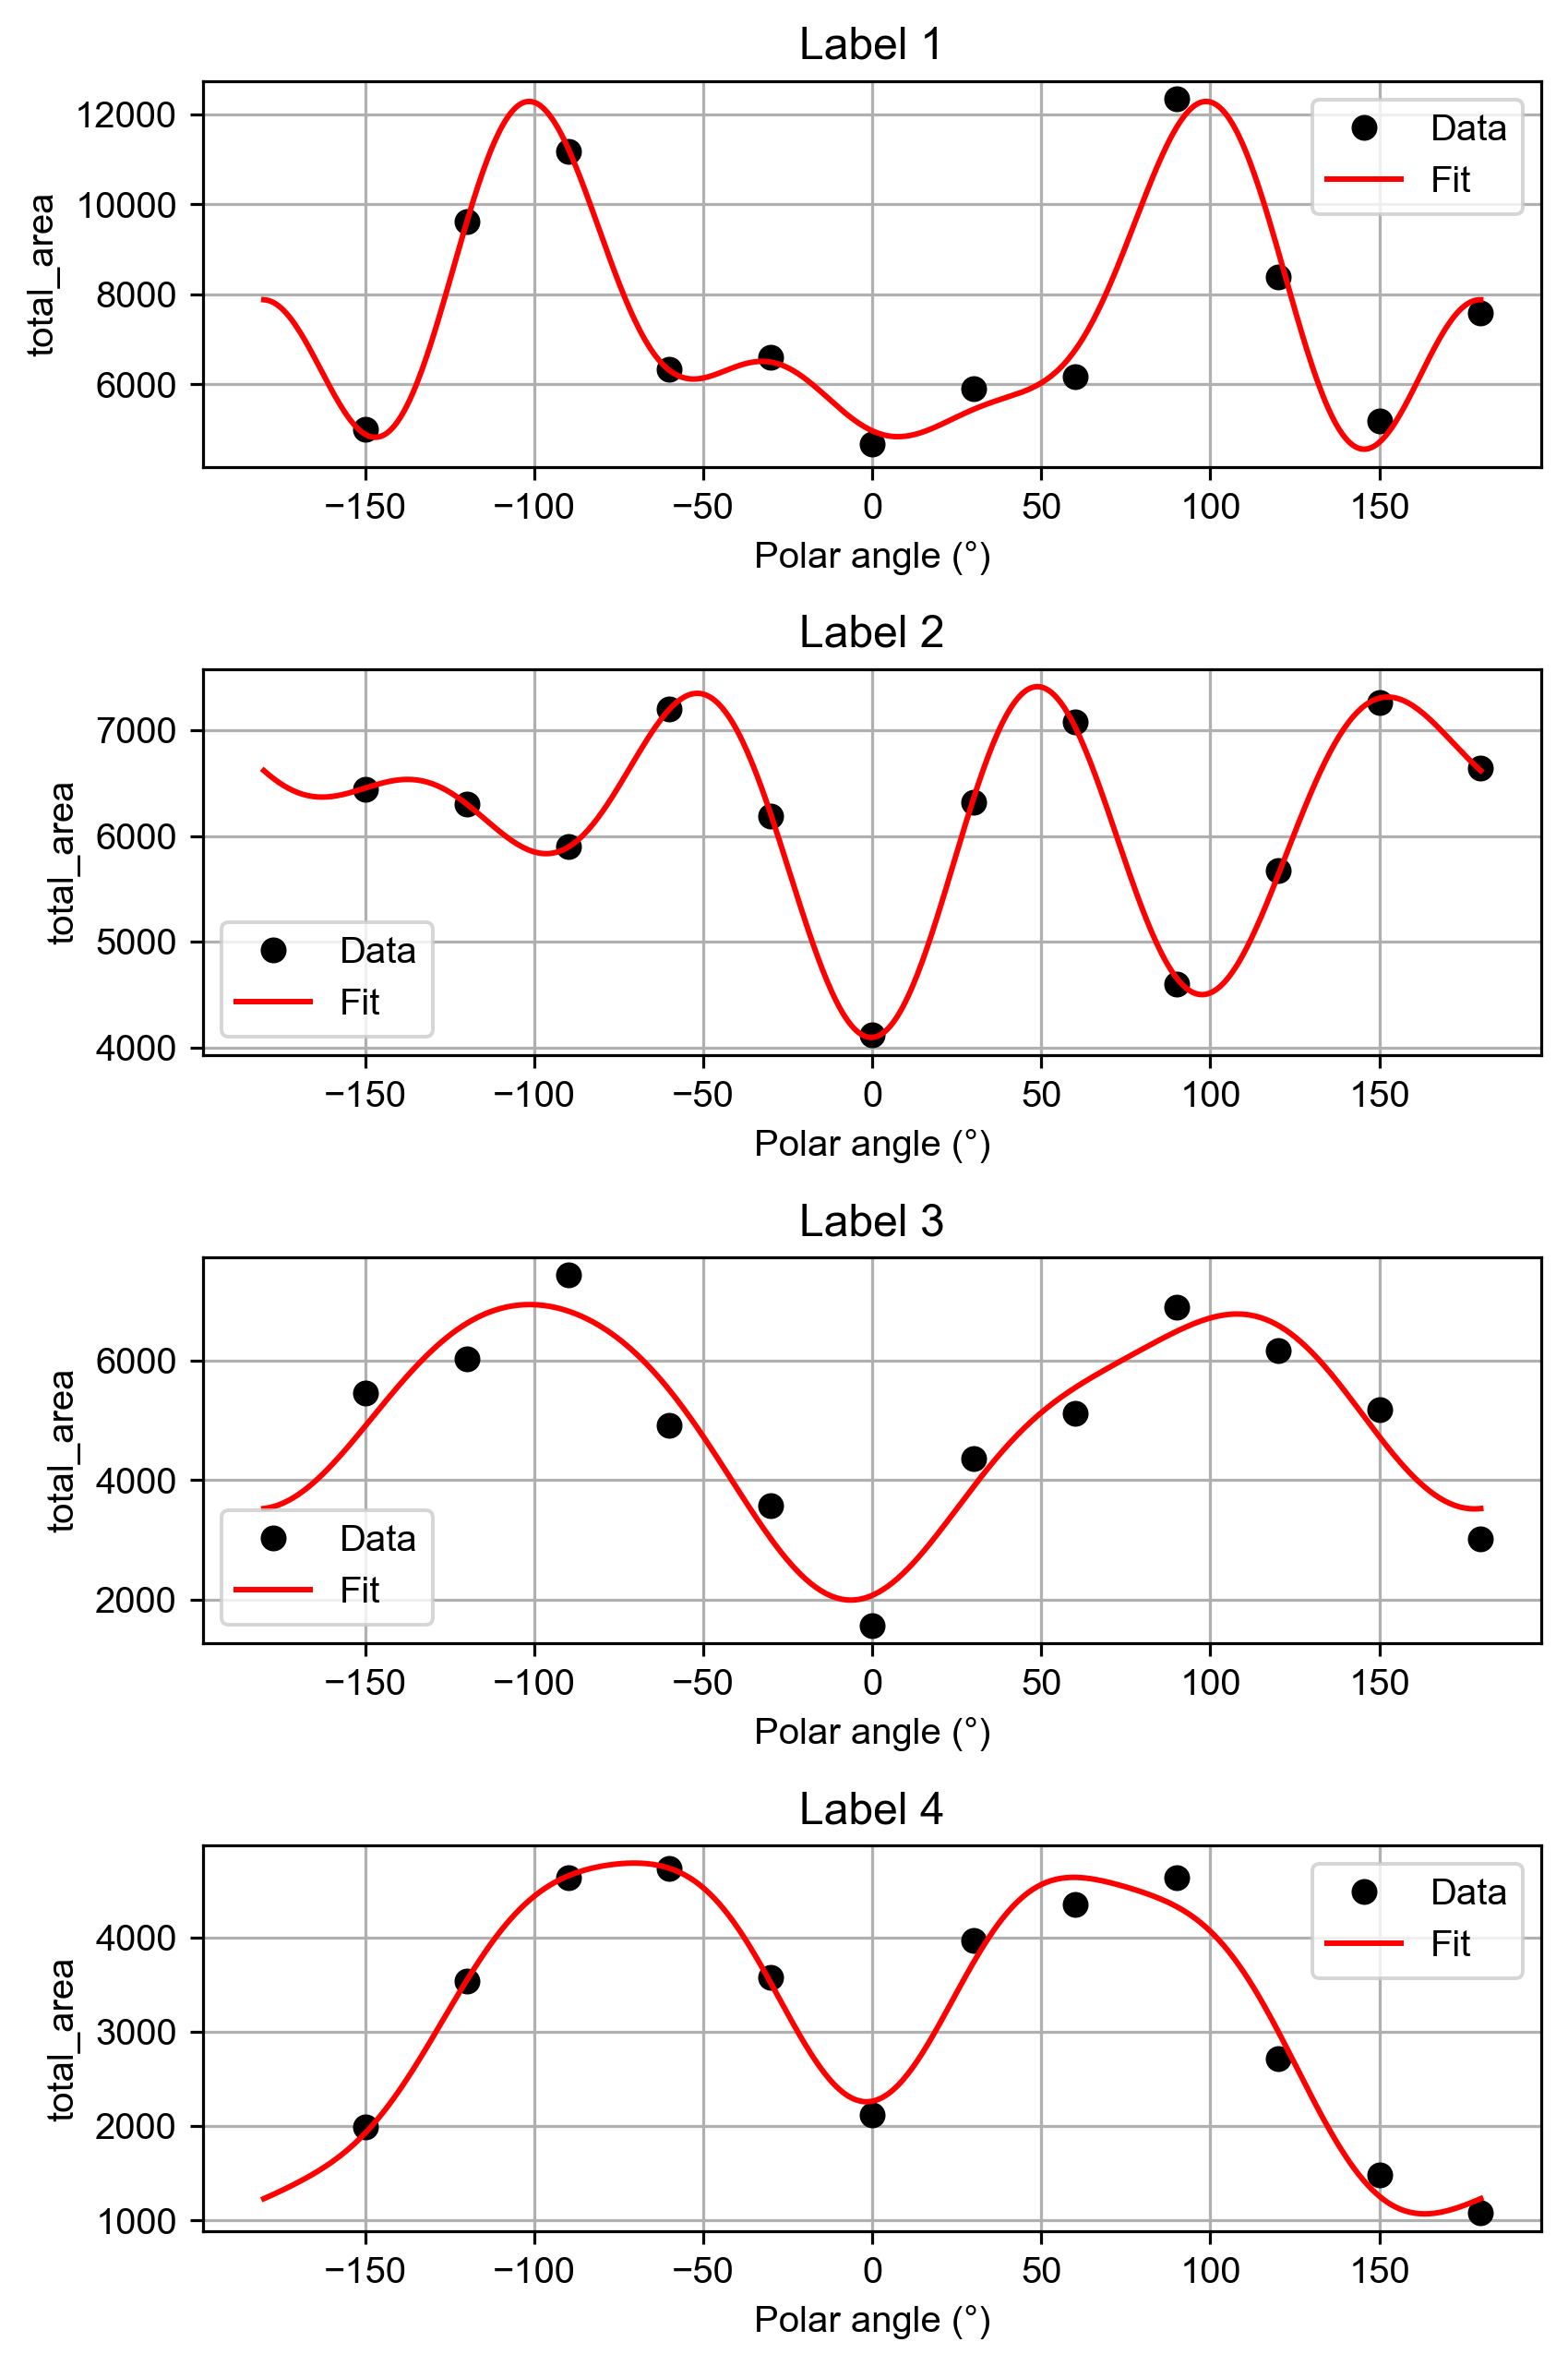

In [31]:
# version 2b: with more params, maybe overfitting
def fourier_model(theta_deg, a0, b1, a1, b2, a2, b3, a3, b4, a4, offset):
    theta_rad = np.radians(theta_deg)
    return (a0 * np.cos(theta_rad) +
            b1 * np.sin(theta_rad) +
            a1 * np.cos(2 * theta_rad) +
            b2 * np.sin(2 * theta_rad) +
            a2 * np.cos(3 * theta_rad) +
            b3 * np.sin(3 * theta_rad) +
            a3 * np.cos(4 * theta_rad) +
            b4 * np.sin(4 * theta_rad) +
            a4 * np.cos(5 * theta_rad) +
            offset)

def loss_fourier(params, theta, y):
    return np.mean((fourier_model(theta, *params) - y) ** 2)

def fit_fourier_model(theta, y):
    # 10 params: a0, b1, a1, b2, a2, b3, a3, b4, a4, offset
    params0 = [0] * 9 + [np.mean(y)]
    result = minimize(loss_fourier, x0=params0, args=(theta, y))
    return result

def print_equation(label, params):
    a0, b1, a1, b2, a2, b3, a3, b4, a4, offset = params
    equation = (f"Label {label}:\n"
                f"f(θ) = {a0:.3f}·cos(θ) + {b1:.3f}·sin(θ) + "
                f"{a1:.3f}·cos(2θ) + {b2:.3f}·sin(2θ) + "
                f"{a2:.3f}·cos(3θ) + {b3:.3f}·sin(3θ) + "
                f"{a3:.3f}·cos(4θ) + {b4:.3f}·sin(4θ) + "
                f"{a4:.3f}·cos(5θ) + {offset:.3f}")
    print(equation)

labels_to_fit = [1, 2, 3, 4]
fig, axs = plt.subplots(len(labels_to_fit), 1, figsize=(6, 9))

for idx, label in enumerate(labels_to_fit):
    data = get_polar_angle_medians(df, label=label, name='')
    if not data:
        continue
    theta_vals, y_vals = zip(*data)
    fit_result = fit_fourier_model(theta_vals, y_vals)
    fit_params = fit_result.x
    theta_pred = np.linspace(-180, 180, 500)
    y_pred = fourier_model(theta_pred, *fit_params)

    print_equation(label, fit_params)

    ax = axs[idx]
    ax.plot(theta_vals, y_vals, 'ko', label='Data')
    ax.plot(theta_pred, y_pred, 'r-', label='Fit')
    ax.set_title(f'Label {label}')
    ax.set_ylabel('total_area')
    ax.set_xlabel('Polar angle (°)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Label 1:
f(θ) = -2525.134·cos(2θ) - -50.169·sin(θ) + 1
Label 2:
f(θ) = 40.515·cos(2θ) - -243.271·sin(θ) + 1
Label 3:
f(θ) = -1930.165·cos(2θ) - 3.408·sin(θ) + 1
Label 4:
f(θ) = -1369.469·cos(2θ) - -182.244·sin(θ) + 1


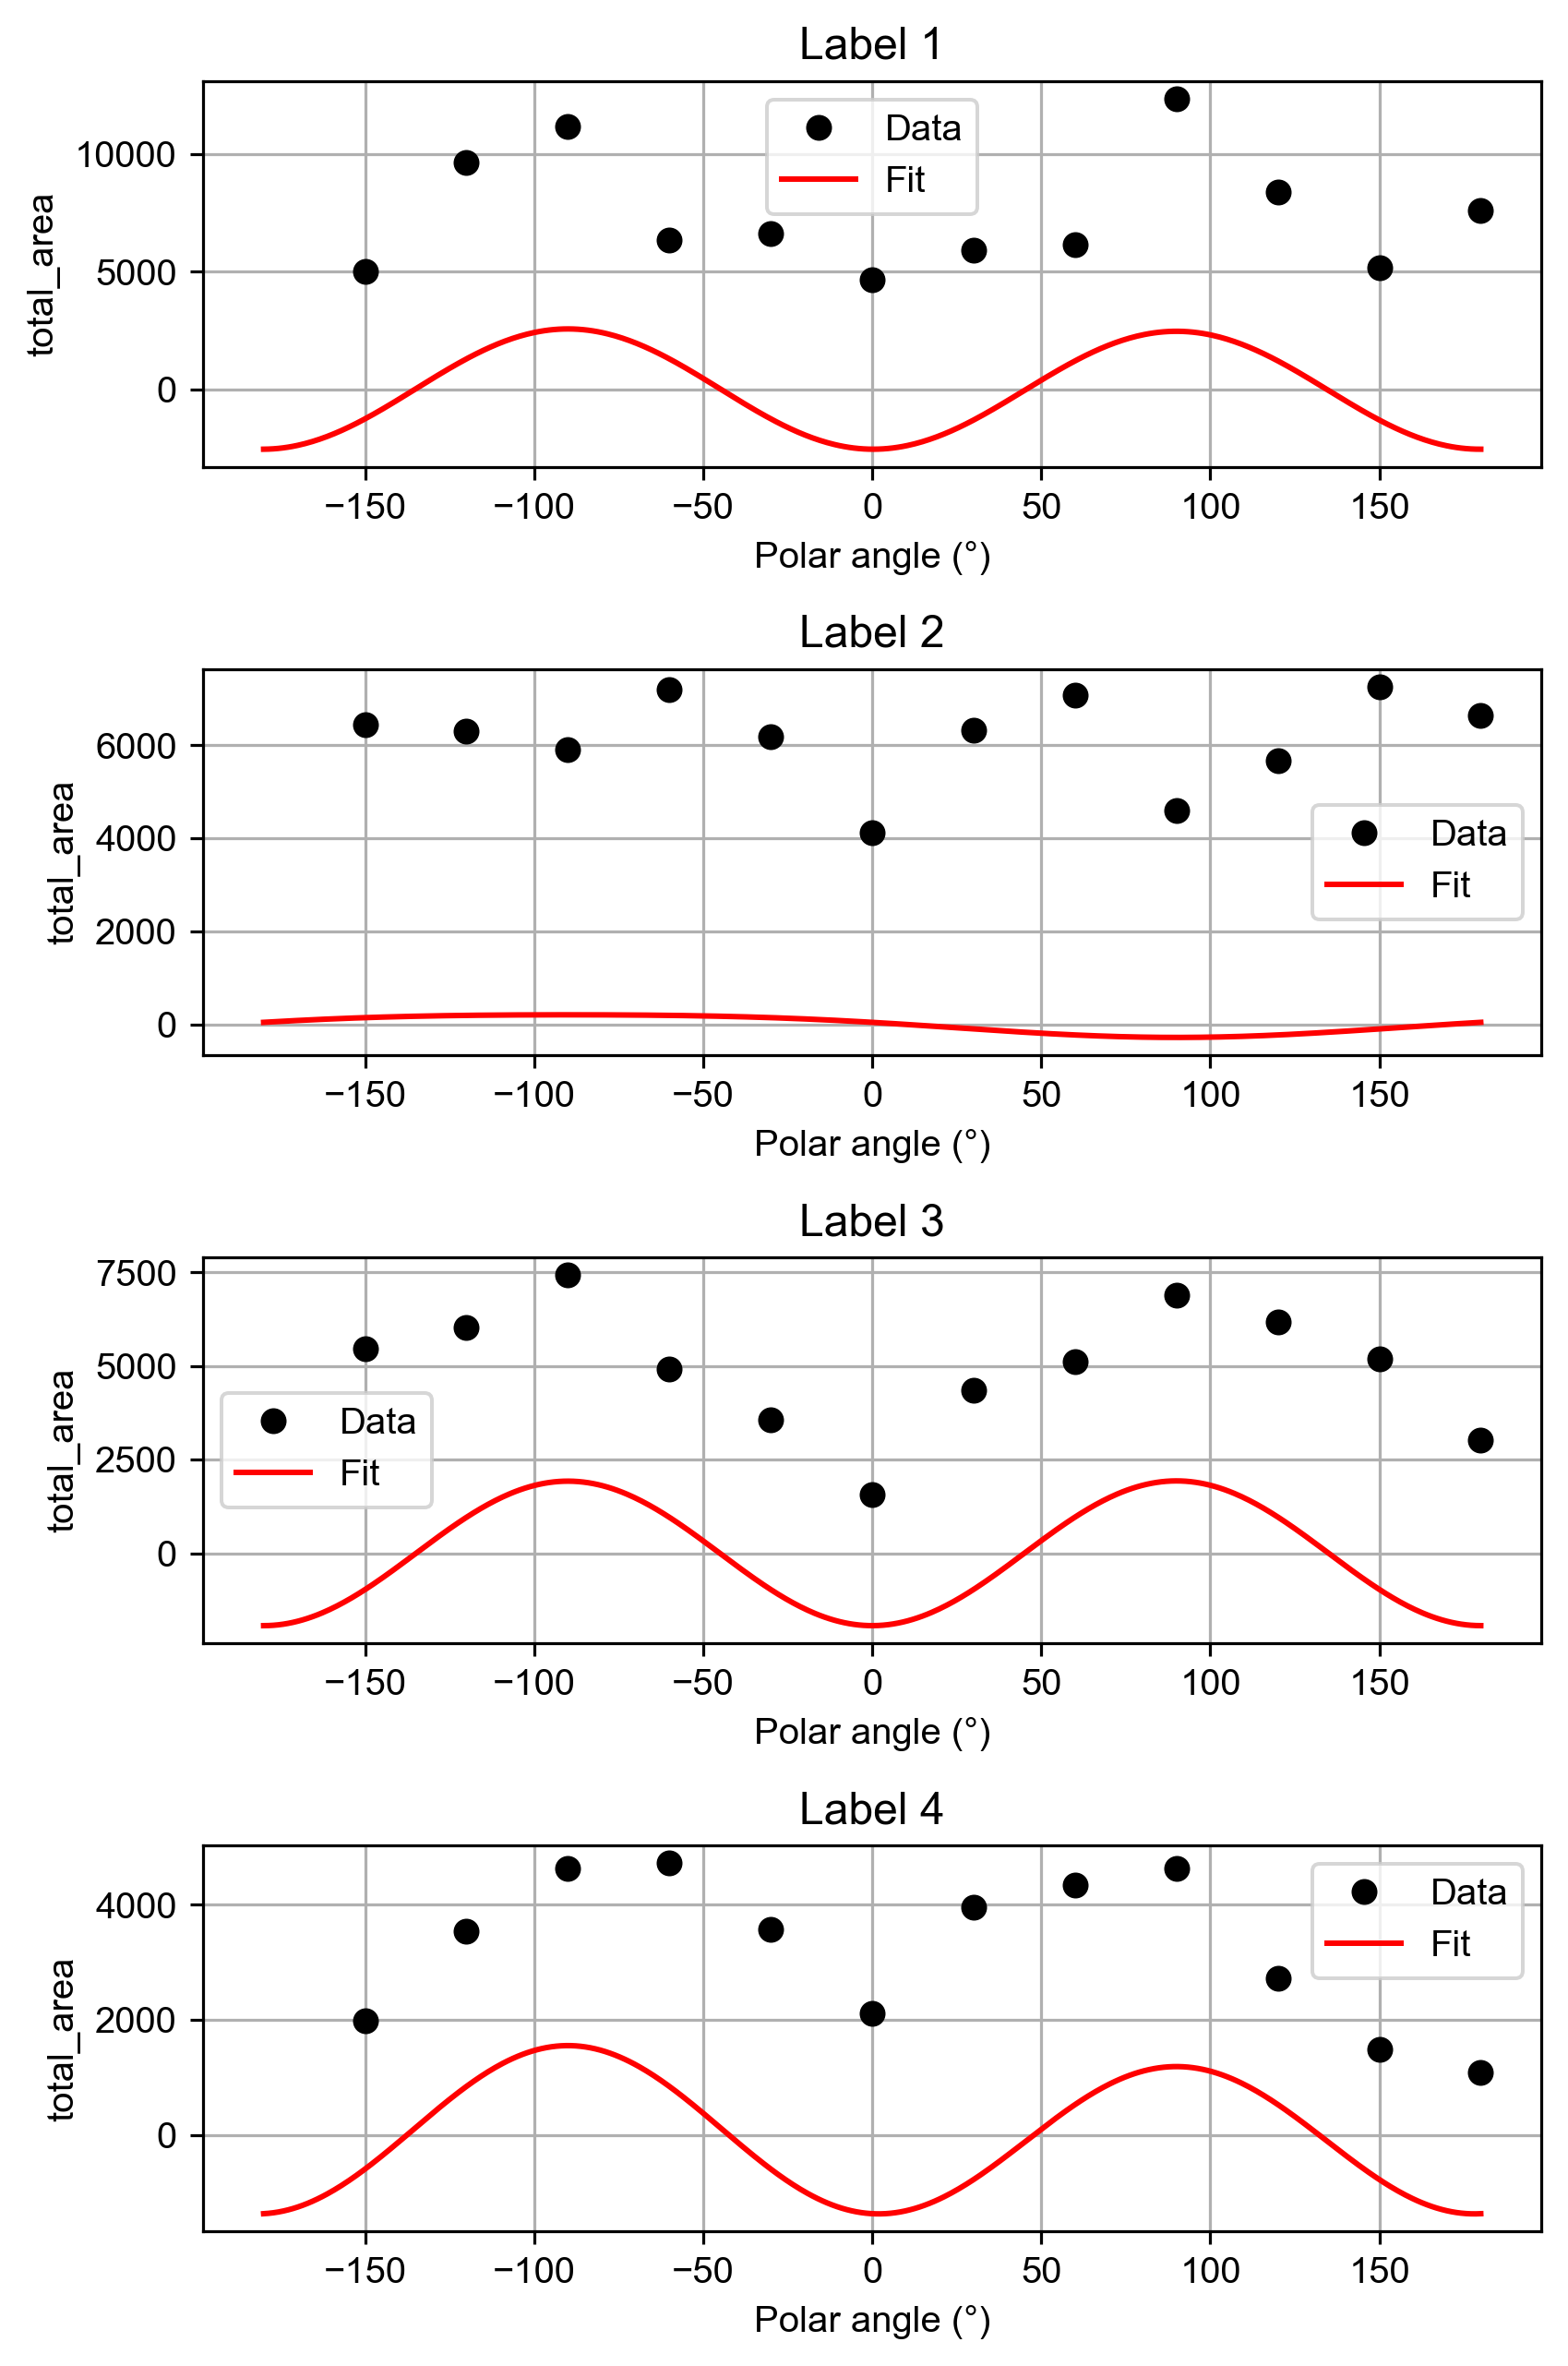

In [44]:
# version3: fit the modulator model in Marc's paper (equation 3)
def fourier_model(theta_deg, a, b, c):
    theta_rad = np.radians(theta_deg)
    return (a * np.cos(2 * theta_rad) +
            b * np.sin(theta_rad) +
            1)

def loss_fourier(params, theta, y):
    return np.mean((fourier_model(theta, *params) - y) ** 2)

def fit_fourier_model(theta, y):
    params0 = [0, 0]  # only a and b
    result = minimize(loss_fourier, x0=params0, args=(theta, y))
    return result

def print_equation(label, params):
    a, b = params
    equation = (f"Label {label}:\n"
                f"f(θ) = {a:.3f}·cos(2θ) - {b:.3f}·sin(θ) + 1")
    print(equation)


labels_to_fit = [1, 2, 3, 4]
fig, axs = plt.subplots(len(labels_to_fit), 1, figsize=(6, 9))

for idx, label in enumerate(labels_to_fit):
    data = get_polar_angle_medians(df, label=label, name='')
    if not data:
        continue
    theta_vals, y_vals = zip(*data)
    fit_result = fit_fourier_model(theta_vals, y_vals)
    fit_params = fit_result.x
    theta_pred = np.linspace(-180, 180, 500)
    y_pred = fourier_model(theta_pred, *fit_params)

    print_equation(label, fit_params)

    ax = axs[idx]
    ax.plot(theta_vals, y_vals, 'ko', label='Data')
    ax.plot(theta_pred, y_pred, 'r-', label='Fit')
    ax.set_title(f'Label {label}')
    ax.set_ylabel('total_area')
    ax.set_xlabel('Polar angle (°)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


# fit cmag using Beta distribution (4 wedges, each 90 deg)

In [ ]:
df = dict(sid=[], h=[], label=[], total_area=[], a=[], b=[], loss=[])

for i in sids:
    (lhdata, rhdata) = data[i]
    for lbl in [1,2,3,4]:
        try:
            fit = cmag.hcp.fit_cmag_data(
            (lhdata, rhdata),
            cmag.models.beta, [0.8,2.5],
            hemifields=2,
            labels=lbl)
        except Exception as e:
            print(f"  - Skipping: {type(e)}")
            continue
        df['sid'].append(i)
        df['h'].append('lr')
        df['label'].append(lbl)
        df['total_area'].append(fit["total_area"])
        df['a'].append(fit.x[0])
        df['b'].append(fit.x[1])
        df['loss'].append(fit.fun)
        
Beta_params = pd.DataFrame(df)

In [ ]:
df = dict(sid=[], h=[], label=[], total_area=[], a=[], b=[], loss=[])

for i in sids:
    (lhdata,rhdata) = data[i]
    
    for lbl in [1,2,3,4]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)  # Ignore RuntimeWarnings
                lhmfit = cmag.hcp.fit_cmag_data(
                (lhdata,rhdata),
                cmag.models.beta, [0.8,2.5],
                hemifields=2*(90/360),
                filter=lambda rhdata: filt_wedge(rhdata, -135, -45),
                labels=lbl)
        except Exception as e:
            print(f"  - Skipping: {type(e)}")
            continue
        df['sid'].append(i)
        df['h'].append('lr')
        df['label'].append(lbl)
        df['total_area'].append(lhmfit["total_area"])
        df['a'].append(lhmfit.x[0])
        df['b'].append(lhmfit.x[1])
        df['loss'].append(lhmfit.fun)
        
Beta_params_lhm = pd.DataFrame(df)


In [ ]:
df = dict(sid=[], h=[], label=[], total_area=[], a=[], b=[], loss=[])

for i in sids:
    (lhdata,rhdata) = data[i]
    
    for lbl in [1,2,3,4]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)  # Ignore RuntimeWarnings
                rhmfit = cmag.hcp.fit_cmag_data(
                (lhdata,rhdata),
                cmag.models.beta, [0.8,2.5],
                hemifields=2*(90/360),
                filter=lambda lhdata: filt_wedge(lhdata, 45, 135),
                labels=lbl)
        except Exception as e:
            print(f"  - Skipping: {type(e)}")
            continue
        df['sid'].append(i)
        df['h'].append('lr')
        df['label'].append(lbl)
        df['total_area'].append(rhmfit["total_area"])
        df['a'].append(rhmfit.x[0])
        df['b'].append(rhmfit.x[1])
        df['loss'].append(rhmfit.fun)
        
Beta_params_rhm = pd.DataFrame(df)

In [ ]:
df = dict(sid=[], h=[], label=[], total_area=[], a=[], b=[], loss=[])

for i in sids:
    (lhdata,rhdata) = data[i]
    subdata = data[i]
    for lbl in [1,2,3,4]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)  # Ignore RuntimeWarnings
                uvmfit = cmag.hcp.fit_cmag_data(
                (lhdata,rhdata),
                cmag.models.beta, [0.8,2.5],
                hemifields=2*(90/360),
                filter=lambda subdata: filt_wedge(subdata, -45, 45),
                labels=lbl)
        except Exception as e:
            print(f"  - Skipping: {type(e)}")
            continue
        df['sid'].append(i)
        df['h'].append('lr')
        df['label'].append(lbl)
        df['total_area'].append(uvmfit["total_area"])
        df['a'].append(uvmfit.x[0])
        df['b'].append(uvmfit.x[1])
        df['loss'].append(uvmfit.fun)
        
Beta_params_uvm = pd.DataFrame(df)

In [ ]:
df = dict(sid=[], h=[], label=[], total_area=[], a=[], b=[], loss=[])

for i in sids:
    (lhdata,rhdata) = data[i]
    subdata = data[i]
    for lbl in [1,2,3,4]:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", RuntimeWarning)  # Ignore RuntimeWarnings
                lvmfit = cmag.hcp.fit_cmag_data(
                (lhdata,rhdata),
                cmag.models.beta, [0.8,2.5],
                hemifields=2*(90/360),
                filter=lambda subdata: filt_wedge(subdata, 135, 180) | filt_wedge(subdata, -180, -135),
                labels=lbl)
        except Exception as e:
            print(f"  - Skipping: {type(e)}")
            continue
        df['sid'].append(i)
        df['h'].append('lr')
        df['label'].append(lbl)
        df['total_area'].append(lvmfit["total_area"])
        df['a'].append(lvmfit.x[0])
        df['b'].append(lvmfit.x[1])
        df['loss'].append(lvmfit.fun)
        
Beta_params_lvm = pd.DataFrame(df)

In [ ]:
## notes from earlier: to be deleted

In [ ]:
# TODO: These are currently broken (use old code) and need to be updated!
# The new code doesn't do the iteration for you, we'll have to iterate
# through the subject IDs and run cmag.hcp.fit_cmag_data() on each subject.

# NOTE: everything below this point in the notebook was originally written
# for the old version of the code and needs to be adapted.

# Fitting beta functions; should take ~2-3 minutes to run.
#
# To fit only wedges (like the upper vertical meridian), we can use the
#   filter=lambda dat: filt_wedge(dat, -15, 15).
# For lower vertical this would be more like:
#   filter=lambda dat: filt_wedge(dat, 165, 180) | filt_wedge(dat, -180, -165)
#
# Keep in mind that the polar_angle data uses 0° as the upper vertical meridian,
# +90° as the right horizontal meridian, -90° as the left horizontal meridian,
# and ±180° as the lower vertical meridian.

fits = {k:[] for k in ('all', 'uvm', 'lvm', 'lhm', 'rhm')}

fits = cmag.hcp.fit_cmag_data(
    data,
    cmag.models.beta, [2, 50],
    lossfn=beta_loss,
    filter=None,
    bilateral=True,
    argtx=beta_argtx)
uvmfits = fitcmag_hcp(
    data, beta_form, [1, 3],
    lossfn=beta_loss,
    filter=lambda dat: filt_wedge(dat, -30, 30),
    bilateral=True,
    argtx=beta_argtx)
lvmfits = fitcmag_hcp(
    data, beta_form, [1, 3],
    lossfn=beta_loss,
    filter=lambda dat: (
        filt_wedge(dat, -180, -150) | filt_wedge(dat, 150, 180)),
    bilateral=True,
    argtx=beta_argtx)
lhmfits = fitcmag_hcp(
    data, beta_form, [1, 3],
    lossfn=beta_loss,
    filter=lambda dat: filt_wedge(dat, -120, -60),
    bilateral=True,
    argtx=beta_argtx)
rvmfits = fitcmag_hcp(
    data, beta_form, [1, 3],
    lossfn=beta_loss,
    filter=lambda dat: filt_wedge(dat, 60, 120),
    bilateral=True,
    argtx=beta_argtx)

### Plotting a Subject's Fits

In [ ]:
sid = 111312

(fig, axs) = plt.subplots(4,2, figsize=(7,7), dpi=288, sharex=True, sharey=True)
fig.subplots_adjust(0,0,1,1,0.15,0.1)
subdat = data[sid]
subfit = fits[sid]

for (ii,axcol) in enumerate(axs.T):
    hdat = subdat[ii]
    hfit = subfit[ii]
    for (lbl,fit,ax) in zip([1,2,3,4], hfit, axcol):
        ii = hdat['label'] == lbl
        ecc = hdat['eccentricity'][ii]
        sar = hdat['surface_area'][ii]
        ii = np.argsort(ecc)
        cum = np.cumsum(sar[ii])
        ecc = ecc[ii]
        ax.plot(ecc, cum, 'k-', lw=0.5)
        pre = cum[-1] * beta_form(ecc, *fit.x)
        ax.plot(ecc, pre, 'r-', lw=0.5)
        ax.fill_between(ecc, cum, pre, color='r', alpha=0.2)

for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0,8])
for ax in axs[:,0]:
    ax.set_ylabel(r'Cum. Surface Area [cm$^2$]')
for ax in axs[-1]:
    ax.set_xlabel('Eccentricity [deg]')

plt.show()

### Plotting Beta Parameters for all Subjects

In [ ]:
def plot_allparams(allparams, figwidth=4, dpi=288):
    nhem = allparams.shape[1]
    figheight = figwidth * 4 / nhem
    (fig,axs) = plt.subplots(
        4, nhem,
        figsize=(figwidth, figheight),
        dpi=dpi,
        sharex=True,
        sharey=True)
    fig.subplots_adjust(0,0,1,1,0.15,0.1)
    if nhem == 1:
        axs = axs[:,None]
    for (hii,axcol) in enumerate(axs.T):
        for (lbl,ax) in zip([1,2,3,4], axcol):
            (x,y) = allparams[:, hii, lbl-1, :].T
            ax.plot(x, y, 'ko', ms=0.5, alpha=0.5)
    for ax in axs.flat:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlim([0,2])
        ax.set_ylim([0,4])
    for ax in axs[:,0]:
        ax.set_ylabel(r'$\beta$')
    for ax in axs[-1]:
        ax.set_xlabel(r'$\alpha$')
    return fig

In [ ]:
allparams = np.array(
    [tuple(
         np.stack([fit.x if fit else (np.nan,np.nan) for fit in hfit])
         for hfit in sfit)
     for sfit in fits.values()])
print(np.nanmean(allparams[:,0,0], axis=0))

fig = plot_allparams(allparams, figwidth=1.5)
plt.show()

In [ ]:
allparams = np.array(
    [tuple(
         np.stack([fit.x if fit else (np.nan,np.nan) for fit in hfit])
         for hfit in sfit)
     for sfit in uvmfits.values()])
print(np.nanmean(allparams[:,0,0], axis=0))

fig = plot_allparams(allparams, figwidth=1.5)
plt.show()

In [ ]:
allparams = np.array(
    [tuple(
         np.stack([fit.x if fit else (np.nan,np.nan) for fit in hfit])
         for hfit in sfit)
     for sfit in lvmfits.values()])
print(np.nanmean(allparams[:,0,0], axis=0))

fig = plot_allparams(allparams, figwidth=1.5)
plt.show()

In [ ]:
allparams = np.array(
    [tuple(
         np.stack([fit.x if fit else (np.nan,np.nan) for fit in hfit])
         for hfit in sfit)
     for sfit in rhmfits.values()])
print(np.nanmean(allparams[:,0,0], axis=0))

fig = plot_allparams(allparams, figwidth=1.5)
plt.show()